# Upload data into session folder
Create new folder called data and put data.csv from [this dataset](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) into it. 

![alternativer Text](https://i.imgur.com/pSRBWIU.png)

# Install d2l lib for plotting

In [4]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l

Looking in links: https://d2l.ai/whl.html


# Data Loading

In [12]:
import pandas as pd
import torch
from torch.utils import data
import numpy as np

discard_features = ['id', 'artists', 'release_date', 'name']
normalize_features = ['duration_ms', 'tempo', 'loudness', 'year', 'popularity']
batch_size = 4


class DataLoader:

    def __init__(self, path, popularity_cutoff=20, validation_split=0.2, shuffle=True):
        self.path = path
        self.popularity_cutoff = popularity_cutoff
        self.validation_split = validation_split
        self.shuffle = shuffle

    def normalize(self, df, columns):
        return df.assign(**{column:
                            (df[column] - df[column].min()) / (df[column].max() - df[column].min())
                            for column in columns})

    def one_hot_encode(self, df, columns):
        return pd.get_dummies(df, columns=columns)


    def get_filtered_songs(self):
        songs = pd.read_csv(self.path)
        popular_songs = songs[songs['popularity'] >= self.popularity_cutoff]
        return popular_songs

    def get_dataset(self):
        filtered_songs = self.get_filtered_songs().drop(discard_features, axis=1)
        normalized = self.normalize(filtered_songs, normalize_features)
        one_hot_encoded = self.one_hot_encode(normalized, ['key'])
        return data.TensorDataset(torch.tensor(one_hot_encoded.values))

    def get_split(self, dataset):
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        split = int(np.floor(self.validation_split * dataset_size))
        if self.shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        return indices[split:], indices[:split]

    def get_preprocessed_data(self):
        dataset = self.get_dataset()
        train_indices, val_indices = self.get_split(dataset)
        train_sampler = data.SubsetRandomSampler(train_indices)
        valid_sampler = data.SubsetRandomSampler(val_indices)

        train_loader = data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        validation_loader = data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
        return train_loader, validation_loader



# Architecture


In [13]:
# https://github.com/avijit9/Contractive_Autoencoder_in_Pytorch/blob/master/CAE_pytorch.py

import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable


class ContractiveAutoencoder(nn.Module):
    """
    Simple contractive autoencoder with a single hidden layer.
    Constructor parameters:
        - num_inputs: Number of input features
        - num_hidden_layer_inputs: Number of input features for the single hidden layer
    """

    def __init__(self, num_inputs, num_hidden_layer_inputs):
        super(ContractiveAutoencoder, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layer_inputs = num_hidden_layer_inputs

        self.fc1 = nn.Linear(num_inputs, num_hidden_layer_inputs, bias=False)  # Encoder
        self.fc2 = nn.Linear(num_hidden_layer_inputs, num_inputs, bias=False)  # Decoder

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x):
        h1 = self.relu(self.fc1(x.view(-1, self.num_inputs)))
        return h1

    def decoder(self, z):
        h2 = self.sigmoid(self.fc2(z))
        return h2

    def forward(self, x):
        h1 = self.encoder(x)
        h2 = self.decoder(h1)
        return h1, h2


def loss_function(W, x, recons_x, h, jacobian_weight):
    """Compute the Contractive AutoEncoder Loss
    Evalutes the CAE loss, which is composed as the summation of a Mean
    Squared Error and the weighted l2-norm of the Jacobian of the hidden
    units with respect to the inputs.
    See reference below for an in-depth discussion:
      #1: http://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder
    Args:
        `W` (FloatTensor): (N_hidden x N), where N_hidden and N are the
          dimensions of the hidden units and input respectively.
        `x` (Variable): the input to the network, with dims (N_batch x N)
        recons_x (Variable): the reconstruction of the input, with dims
          N_batch x N.
        `h` (Variable): the hidden units of the network, with dims
          batch_size x N_hidden
        `jacobian_weight` (float): the weight given to the jacobian regulariser term
    Returns:
        Variable: the (scalar) CAE loss
    """
    mse_loss = nn.MSELoss(size_average=False)
    mse = mse_loss(recons_x, x)
    # Since: W is shape of N_hidden x N. So, we do not need to transpose it as
    # opposed to #1
    dh = h * (1 - h)  # Hadamard product produces size N_batch x N_hidden
    # Sum through the input dimension to improve efficiency, as suggested in #1
    w_sum = torch.sum(Variable(W) ** 2, dim=1)
    # unsqueeze to avoid issues with torch.mv
    w_sum = w_sum.unsqueeze(1)  # shape N_hidden x 1
    contractive_loss = torch.sum(torch.mm(dh ** 2, w_sum), 0)
    return mse + contractive_loss.mul_(jacobian_weight)

# Training

===SUMMARY===
====> Epoch: 1 Average loss: 0.5274
====> Epoch: 2 Average loss: 0.1862
====> Epoch: 3 Average loss: 0.1498
====> Epoch: 4 Average loss: 0.1366
====> Epoch: 5 Average loss: 0.1283
====> Epoch: 6 Average loss: 0.1165
====> Epoch: 7 Average loss: 0.1010
====> Epoch: 8 Average loss: 0.0929
====> Epoch: 9 Average loss: 0.0890
====> Epoch: 10 Average loss: 0.0868


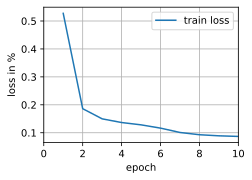

In [14]:
import torch
import torch.optim as optim
from d2l import torch as d2l

class ModelTrainer:
    r"""
        Model trainer. Performs the training on the model by calling ModelTrainer.train()
        Arguments:
            model: The model to train
            loader: The data loader
            num_inputs (int): Number of input features.
            jacobian_weight (float): the weight given to the jacobian regulariser term.
            num_epochs (int): Number of epochs to perform on training
            learning_rate (float): The learning rate to apply
        """
    def __init__(self, model, loader, num_inputs, jacobian_weight=1e-4, num_epochs=15, learning_rate=0.0001):
        self.model = model
        self.num_inputs = num_inputs
        self.jacobian_weight = jacobian_weight
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate

        self.loader = loader
        train_loader, validation_loader = loader.get_preprocessed_data()
        self.train_loader = train_loader
        self.validation_loader = validation_loader

        self.model = self.model.double()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def get_model(self):
        return self.model

    def set_model(self, model):
        self.model = model

    def get_optimizer(self):
        return self.optimizer

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def get_model_weights(self):
        return self.model.state_dict()['fc1.weight']

    def train(self):
        animator = d2l.Animator(ylabel='loss in %', xlabel='epoch', xlim=[0, self.num_epochs],
                            legend=['train loss'])
        avg_losses_per_epoch = []
        for epoch in range(self.num_epochs):
            count = 0
            self.model.train()
            train_loss = 0
            for data in self.train_loader:
                self.optimizer.zero_grad()
                data_as_tensor = data[0].double()
                hidden_representation, reconstruction_x = self.model(data_as_tensor)

                weights = self.get_model_weights()
                loss = loss_function(weights, data_as_tensor.view(-1, self.num_inputs), reconstruction_x,
                                     hidden_representation, self.jacobian_weight)

                loss.backward()
                train_loss += loss.data[0]
                self.optimizer.step()
                count += 1

            avg_train_loss = train_loss / len(self.train_loader.dataset)
            animator.add(epoch + 1, avg_train_loss.item())
            avg_losses_per_epoch.append(avg_train_loss)

        print('===SUMMARY===')
        epoch_idx = 1
        for avg_loss in avg_losses_per_epoch:
            print('====> Epoch: {} Average loss: {:.4f}'.format(epoch_idx, avg_loss))
            epoch_idx += 1

    def save_model(self, path='model.pt'):
        torch.save(self.model.state_dict(), path)


num_inputs = 26
num_hidden_layer_inputs = 10
jacobian_weight = 1e-4
num_epochs = 10
learning_rate = 0.001
save_path = 'model.pt'

if __name__ == '__main__':

    autoencoder_model = ContractiveAutoencoder(num_inputs, num_hidden_layer_inputs)
    loader = DataLoader('data/data.csv')
    # instantiate model trainer
    model_trainer = ModelTrainer(autoencoder_model, loader, num_inputs, jacobian_weight, num_epochs, learning_rate)
    # perform training
    model_trainer.train()
    # save model
    model_trainer.save_model(save_path)

# Get Recommendations

In [9]:
import torch
import numpy

def print_song_information(song):
    print("Song name: {}".format(song['name']))
    print("Song artists: {}".format(song['artists']))
    print("Spotify URI: spotify:track:{}".format(song['id']))
    print("Spotify URL: https://open.spotify.com/track/{}".format(song['id']))


def get_song_index(spotify_id, available_songs):
    query_result = available_songs[available_songs['id'] == spotify_id.strip()]
    query_result_row_indices = query_result.index.values.astype(int)
    if len(query_result_row_indices) > 0:
        dataframe_song_index = query_result_row_indices[0]
        # since the input dataframe could be filtered the dataframe index might not be the real index anymore
        # this is why a search for the first occurence of the dataframe index is needed to get the absolute index
        absolute_song_index = numpy.where(available_songs.index.values == dataframe_song_index)[0][0]
        return absolute_song_index
    else:
        print(
            "Could not find song with that ID, maybe it got filtered out in preprocessing or the ID doesn't exist")
        return None

def prompt_user_for_song(available_songs):
    """
    Asks the user for a Spotify song id and returns the
    row index of that song in the given DataFrame (absolute index)

    :param available_songs: songs that are available to input (pandas.DataFrame)
    :return: index of user input song (number)
    """
    absolute_song_index = None
    did_find_song_or_exited = False
    while not did_find_song_or_exited:
        input_id = input("Please input Spotify Song id: \n")
        absolute_index = get_song_index(input_id, available_songs)
        if absolute_index is not None:
          return absolute_index

    # return absolute_song_index


def get_song_recommendations(input_song_index, k, loader):
    """
    :param input_song_index: Index of the song to search similar songs for
    :param k: Top k nearest songs
    :param loader: DataLoader
    :return: list of DataFrame rows (pandas.core.series.Series)
    """
    # load model parameters from disk and initialize model with it
    trained_model = ContractiveAutoencoder(num_inputs, num_hidden_layer_inputs).double()
    trained_model.load_state_dict(torch.load(save_path))
    trained_model.eval()

    song_dataset = loader.get_dataset()
    all_songs = loader.get_filtered_songs()

    print("Found song: ")
    input_song = all_songs.iloc[input_song_index]
    print_song_information(input_song)

    print('')
    print('Searching for top {} similar songs..'.format(k))

    """
    Compute dense song representation for every song of the data set and create tensor from it
    """
    all_songs_dense_list = []
    for song in song_dataset:
        dense_song_representation, song_reconstruction = trained_model(song[0])
        all_songs_dense_list.append(dense_song_representation)
    all_songs_dense = torch.cat(all_songs_dense_list)

    input_song_dense = all_songs_dense[input_song_index]

    """
    Drop the input song from the dense representations and meta lookup, so we don't compare input with itself
    """
    all_songs_without_input_song = all_songs.drop(all_songs.index[input_song_index])
    all_songs_dense_without_input_song = torch.cat(
        (all_songs_dense[0:input_song_index], all_songs_dense[input_song_index + 1:]))

    """
    Search top k nearest songs based on the euclidean distance
    between the input dense representation and all other representations.
    """
    euclidean_distances = torch.norm(all_songs_dense_without_input_song - input_song_dense, dim=1, p=None)
    topk_nearest_songs = euclidean_distances.topk(k, largest=False)

    recommendations = []
    for index_tensor in topk_nearest_songs.indices:
        index = index_tensor.item()
        recommended_song = all_songs_without_input_song.iloc[index]
        recommendations.append(recommended_song)

    return recommendations


def print_recommendations(recommendations):
    print('')
    print("======RESULT======")
    rank = 1
    for song in recommendations:
        print(rank)
        print_song_information(song)
        print("==================")
        rank += 1

# Example songs

Note: If the execution of any of the following examples is not saved then please execute the cell below

## Blinding Lights - The Weeknd
https://open.spotify.com/track/0VjIjW4GlUZAMYd2vXMi3b

In [17]:
loader = DataLoader('data/data.csv')
input_song_index = get_song_index('0VjIjW4GlUZAMYd2vXMi3b', loader.get_filtered_songs())
print(input_song_index is None)
recommendations = get_song_recommendations(input_song_index, 10, loader)
print_recommendations(recommendations)

False
Found song: 
Song name: Blinding Lights
Song artists: ['The Weeknd']
Spotify URI: spotify:track:0VjIjW4GlUZAMYd2vXMi3b
Spotify URL: https://open.spotify.com/track/0VjIjW4GlUZAMYd2vXMi3b

Searching for top 10 similar songs..

======RESULT======
1
Song name: Into the Unknown - Panic! At The Disco Version
Song artists: ['Panic! At The Disco']
Spotify URI: spotify:track:421eObjg0DTm2qajJl5OJm
Spotify URL: https://open.spotify.com/track/421eObjg0DTm2qajJl5OJm
2
Song name: This Feeling
Song artists: ['The Chainsmokers', 'Kelsea Ballerini']
Spotify URI: spotify:track:4NBTZtAt1F13VvlSKe6KTl
Spotify URL: https://open.spotify.com/track/4NBTZtAt1F13VvlSKe6KTl
3
Song name: One Dance
Song artists: ['Drake', 'WizKid', 'Kyla']
Spotify URI: spotify:track:1zi7xx7UVEFkmKfv06H8x0
Spotify URL: https://open.spotify.com/track/1zi7xx7UVEFkmKfv06H8x0
4
Song name: Daisies
Song artists: ['Katy Perry']
Spotify URI: spotify:track:4uqh9bualXNHXXwO2wPorc
Spotify URL: https://open.spotify.com/track/4uqh9bualXN

## Billie Eilish - bad guy
https://open.spotify.com/track/2Fxmhks0bxGSBdJ92vM42m


In [18]:
loader = DataLoader('data/data.csv')
input_song_index = get_song_index('2Fxmhks0bxGSBdJ92vM42m', loader.get_filtered_songs())
recommendations = get_song_recommendations(input_song_index, 10, loader)
print_recommendations(recommendations)

Found song: 
Song name: bad guy
Song artists: ['Billie Eilish']
Spotify URI: spotify:track:2Fxmhks0bxGSBdJ92vM42m
Spotify URL: https://open.spotify.com/track/2Fxmhks0bxGSBdJ92vM42m

Searching for top 10 similar songs..

======RESULT======
1
Song name: Easy - Remix
Song artists: ['DaniLeigh', 'Chris Brown']
Spotify URI: spotify:track:4CMrdHWqic0usIZfTrKoI3
Spotify URL: https://open.spotify.com/track/4CMrdHWqic0usIZfTrKoI3
2
Song name: Psycho!
Song artists: ['MASN']
Spotify URI: spotify:track:5LKkteRQ1wWv7XCIEA5F2q
Spotify URL: https://open.spotify.com/track/5LKkteRQ1wWv7XCIEA5F2q
3
Song name: I'll Make a Man Out of You - From "Mulan"/Soundtrack
Song artists: ['Donny Osmond', 'Chorus - Mulan']
Spotify URI: spotify:track:28UMEtwyUUy5u0UWOVHwiI
Spotify URL: https://open.spotify.com/track/28UMEtwyUUy5u0UWOVHwiI
4
Song name: Cherry
Song artists: ['Harry Styles']
Spotify URI: spotify:track:2IOFZdYYkFxEHVz1w34PoL
Spotify URL: https://open.spotify.com/track/2IOFZdYYkFxEHVz1w34PoL
5
Song name: L

## AC/DC - You Shook Me All Night Long

https://open.spotify.com/track/2SiXAy7TuUkycRVbbWDEpo

In [19]:
loader = DataLoader('data/data.csv')
input_song_index = get_song_index('2SiXAy7TuUkycRVbbWDEpo', loader.get_filtered_songs())
recommendations = get_song_recommendations(input_song_index, 10, loader)
print_recommendations(recommendations)

Found song: 
Song name: You Shook Me All Night Long
Song artists: ['AC/DC']
Spotify URI: spotify:track:2SiXAy7TuUkycRVbbWDEpo
Spotify URL: https://open.spotify.com/track/2SiXAy7TuUkycRVbbWDEpo

Searching for top 10 similar songs..

======RESULT======
1
Song name: Carry on Wayward Son
Song artists: ['Kansas']
Spotify URI: spotify:track:4DMKwE2E2iYDKY01C335Uw
Spotify URL: https://open.spotify.com/track/4DMKwE2E2iYDKY01C335Uw
2
Song name: Paperback Writer - Remastered 2015
Song artists: ['The Beatles']
Spotify URI: spotify:track:0Ui8KPWZbJJQ2Y0CIQuVqX
Spotify URL: https://open.spotify.com/track/0Ui8KPWZbJJQ2Y0CIQuVqX
3
Song name: Fly Away
Song artists: ['Lenny Kravitz']
Spotify URI: spotify:track:1OxcIUqVmVYxT6427tbhDW
Spotify URL: https://open.spotify.com/track/1OxcIUqVmVYxT6427tbhDW
4
Song name: Igual Que Ayer
Song artists: ['Los Enanitos Verdes']
Spotify URI: spotify:track:2JlVEgNJwskpAGSudKPqLD
Spotify URL: https://open.spotify.com/track/2JlVEgNJwskpAGSudKPqLD
5
Song name: Rivers of B